# NLP applied to classify Spanish jokes

In this notebook we will be applying different Natural Language Processing techniques to a corpus of jokes in Spanish.
The **objective** is to **train a Machine Learning model to classify jokes in categories**.

In order to execute smoothly the code, you should've installed the requirements using `pipenv` or `pip` (refer to the README.md for details).

Actually we will be using **pandas** to do a first exploration of the dataset, **spacy (with Spanish package installed)** to extract Natural Language information from the jokes, and **sklearn** to vectorize the jokes and train a Machine Learning model to classify jokes.

## Importing basic libraries

In [1]:
# jupyter config
import warnings
warnings.filterwarnings('ignore')

# data science stack
import numpy as np
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.3f' % x)
import matplotlib.pyplot as plt
%matplotlib inline

## Reading the dataset

In [2]:
df = pd.read_csv('data/chistes.csv', index_col='id', dtype={'text':str})
df.head()

,text,keywords,funny,category
id,,,,
0,"- ¡Rápido, necesitamos sangre!\n- Yo soy 0 pos...",sangre,1,otros
1,- ¿Cuál es el mejor portero del mundial? \n- E...,"futbol,porteros",1,otros
2,El otro día unas chicas llamarón a mi puerta y...,"dinero,agua",1,otros
3,"- Andresito, ¿qué planeta va después de Marte?...",planetas,1,profesiones
4,- ¿Por qué Bob Esponja no va al gimnasio? \n- ...,"esponja,gimnasios",1,otros


We will be focusing on joke's text and category. Let's see how many jokes do we have and the different categories.

In [3]:
df.shape

(2419, 4)

So we have ~2400 jokes with 4 columns defining jokes' details. Let's explore how many categories are in this dataset.

In [4]:
df['category'].value_counts()

otros          770
familia        580
sexo           353
animales       229
profesiones    199
regionales     194
tematicos       94
Name: category, dtype: int64

In [5]:
df['category'].value_counts()/df.shape[0]

otros         0.318
familia       0.240
sexo          0.146
animales      0.095
profesiones   0.082
regionales    0.080
tematicos     0.039
Name: category, dtype: float64

So we have 7 categories, being the most common "otros" with a 31.8%.

Let's explore the size of the jokes too.

In [6]:
df['len'] = df['text'].apply(lambda t: len(t))

df['len'].describe()

count   2419.000
mean     278.678
std      308.957
min       31.000
25%      107.000
50%      160.000
75%      314.000
max     2836.000
Name: len, dtype: float64

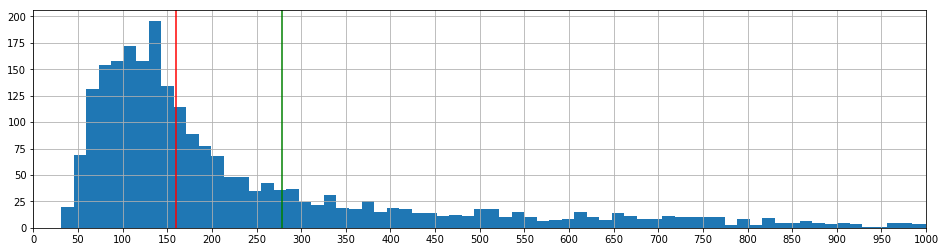

In [7]:
df['len'].hist(bins=200, figsize=(16, 4))

plt.xticks(range(0,2000,50))
plt.xlim((0,1000))
plt.axvline(df['len'].median(), color='r')  # Median in red
plt.axvline(df['len'].mean(), color='g')  # Mean in green


Half of the jokes have a size below 160 characters, which looks like really short documents to try NLP.


## Using spacy info

We will load Spanish module in spacy and try to get Part Of Speech (POS) of each word and other information.

In [8]:
import spacy
nlp = spacy.load("es")
nlp

Let's try to get a random joke and process it with spacy.

In [9]:
random_joke = df.iloc[10]['text']

print(random_joke)

- Qué es un pelo en una cama?
- ...
- El bello durmiente


In [10]:
processed_joke = nlp(random_joke)

for token in processed_joke:
    print(token.text,'\t lemma:', token.lemma_, ', pos:', token.pos_, ', tag:', token.tag_, ', stopword:', token.is_stop)

- 	 lemma: - , pos: PUNCT , tag: PUNCT__PunctType=Dash , stopword: False
Qué 	 lemma: Qué , pos: PRON , tag: PRON__Number=Sing|PronType=Int , stopword: True
es 	 lemma: ser , pos: AUX , tag: AUX__Mood=Ind|Number=Sing|Person=3|Tense=Pres|VerbForm=Fin , stopword: True
un 	 lemma: uno , pos: DET , tag: DET__Definite=Ind|Gender=Masc|Number=Sing|PronType=Art , stopword: True
pelo 	 lemma: pelar , pos: NOUN , tag: NOUN__Gender=Masc|Number=Sing , stopword: False
en 	 lemma: en , pos: ADP , tag: ADP__AdpType=Prep , stopword: True
una 	 lemma: uno , pos: DET , tag: DET__Definite=Ind|Gender=Fem|Number=Sing|PronType=Art , stopword: True
cama 	 lemma: cama , pos: NOUN , tag: NOUN__Gender=Fem|Number=Sing , stopword: False
? 	 lemma: ? , pos: PUNCT , tag: PUNCT__PunctSide=Fin|PunctType=Qest , stopword: False

 	 lemma: 
 , pos: SPACE , tag: _SP , stopword: False
- 	 lemma: - , pos: PUNCT , tag: PUNCT__PunctType=Dash , stopword: False
... 	 lemma: ... , pos: PUNCT , tag: PUNCT__PunctType=Comm , stopw

Spacy provides us with some useful information. In this case:
* lemma: the *dictionary form* of the word
* pos: part of speech, for example: noun, verb, adjective...
* tag: part of speech with extended info, like gender, number, etc
* stopword: if the word is considered meaningless (for NLP tasks) or not

As you see, spacy sometimes gives us wrong info:
* the lemma of "pelo" should be "pelo"(noun) and not "pelar"(verb)
* "durmiente" should've been tagged as noun, but it's tagged as adverb

Let's stress spacy with a *classic* complex sentence:

In [11]:
complex_sentence = 'Bajo con un tipo bajo a tocar el bajo bajo la escalera.'
processed = nlp(complex_sentence)
for token in processed:
    print(token.text, token.tag_)

Bajo ADP__AdpType=Prep
con ADP__AdpType=Prep
un DET__Definite=Ind|Gender=Masc|Number=Sing|PronType=Art
tipo NOUN__Gender=Masc|Number=Sing
bajo ADJ__Gender=Masc|Number=Sing
a ADP__AdpType=Prep
tocar VERB__VerbForm=Inf
el DET__Definite=Def|Gender=Masc|Number=Sing|PronType=Art
bajo ADJ__Gender=Masc|Number=Sing
bajo ADP__AdpType=Prep
la DET__Definite=Def|Gender=Fem|Number=Sing|PronType=Art
escalera NOUN__Gender=Fem|Number=Sing
. PUNCT__PunctType=Peri


The first "bajo" should be a verb, but it was tagged as preposition. However the other 3 "bajo" are correctly labeled.

## Using scikit-learn for vectorization

An easy way to convert a document into numbers (so algorithms can be easily applied to) is to count the words it contains. Usually it's better to consider only words that have strong meaning, and in our case (try to classify documents) it's important to find words that are common enough, to convert them into "features", but not too common, so they can help us classifying the documents.

In sklearn there are several methods to count words from documents. In the next example, we will be looking for the 20 most common words, but that appear in less than 200 jokes.

In [12]:
from sklearn.feature_extraction.text import CountVectorizer

max_jokes_with_that_word = 200

vectorizer20 = CountVectorizer(max_df=max_jokes_with_that_word, max_features=20)
bag_of_words = vectorizer20.fit_transform(df.text)

vectorizer20.get_feature_names()

['bien',
 'casa',
 'contesta',
 'doctor',
 'día',
 'entonces',
 'esta',
 'hace',
 'he',
 'hijo',
 'jaimito',
 'mamá',
 'marido',
 'nada',
 'señor',
 'soy',
 'sí',
 'tan',
 'tengo',
 'tiene']

The most relevant words are a mix of good ones (like "doctor") and not so good (like "soy"). The result is a *bag of words*, that is, a matrix with the counts of each relevant words in each joke.

The bag of words here is a sparse matrix, but we can convert it to a pandas dataframe.

In [13]:
bag_of_words

<2419x20 sparse matrix of type '<class 'numpy.int64'>'
	with 3116 stored elements in Compressed Sparse Row format>

In [14]:
counted = pd.DataFrame(data=bag_of_words.toarray(), index=df.index, columns=vectorizer20.get_feature_names())
counted.head(20)

,bien,casa,contesta,doctor,día,entonces,esta,hace,he,hijo,jaimito,mamá,marido,nada,señor,soy,sí,tan,tengo,tiene
id,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,1,0,0,0


So, for example, the word "mamá" appears 2 times in the joke with id=7.

## Filtering words

Let's try to keep only words with real meaning. A classic way to do so is removing all the stopwords, but here we can leverage spacy extra information and keep only nouns, verbs, adjectives and adverbs.

In the old times they used to process the words with a stemmer (that removes the ending "s" and some other tricks), but we are going to normalize the words using their lemma.

In [15]:
def keep_only_content_words(s):
    processed = nlp(s)
    result = [token.lemma_ for token in processed if token.pos_ in ('NOUN', 'VERB', 'ADJ', 'ADV')]
    return ' '.join(result)

print(random_joke)
print()
print(keep_only_content_words(random_joke))

- Qué es un pelo en una cama?
- ...
- El bello durmiente

pelar cama bello durmiente


In [16]:
df['filtered_text'] = df['text'].apply(keep_only_content_words)
df.head()

,text,keywords,funny,category,len,filtered_text
id,,,,,,
0,"- ¡Rápido, necesitamos sangre!\n- Yo soy 0 pos...",sangre,1,otros,105,Rápido necesitar sangrar positivo muy mal nece...
1,- ¿Cuál es el mejor portero del mundial? \n- E...,"futbol,porteros",1,otros,70,mejor portero mundial Evidente guay
2,El otro día unas chicas llamarón a mi puerta y...,"dinero,agua",1,otros,131,día chico llamarón puerta pedir pequeño donaci...
3,"- Andresito, ¿qué planeta va después de Marte?...",planetas,1,profesiones,69,planeta ir después señorito
4,- ¿Por qué Bob Esponja no va al gimnasio? \n- ...,"esponja,gimnasios",1,otros,69,no ir gimnasio ya cuadrar


Now let's try again to find the most common 20 words, only using the filtered words.

In [17]:
vectorizer20 = CountVectorizer(max_df=max_jokes_with_that_word, max_features=20)
bag_of_words = vectorizer20.fit_transform(df.filtered_text)

vectorizer20.get_feature_names()

['año',
 'bien',
 'bueno',
 'contestar',
 'día',
 'encontrar',
 'entonces',
 'estar',
 'llamar',
 'llegar',
 'maridar',
 'mirar',
 'niño',
 'pasar',
 'saber',
 'salir',
 'sí',
 'tan',
 'venir',
 'vez']

In [18]:
# Let's see it in a table
counted = pd.DataFrame(data=bag_of_words.toarray(), index=df.index, columns=vectorizer20.get_feature_names())
counted.head(20)

,año,bien,bueno,contestar,día,encontrar,entonces,estar,llamar,llegar,maridar,mirar,niño,pasar,saber,salir,sí,tan,venir,vez
id,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


### tf-idf

A better way to make numerical values of the words is using tf-idf (term frequency, inverse document frequency). Let's apply it to our bag_of_words.

In [19]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_trans = TfidfTransformer()

normalized_bag = tfidf_trans.fit_transform(bag_of_words)

In [20]:
# Display word importance
pd.DataFrame(data=normalized_bag.toarray(), index=df.index, columns=vectorizer20.get_feature_names()).head(25)

,año,bien,bueno,contestar,día,encontrar,entonces,estar,llamar,llegar,maridar,mirar,niño,pasar,saber,salir,sí,tan,venir,vez
id,,,,,,,,,,,,,,,,,,,,
0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
3,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
4,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
5,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
6,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
7,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
8,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000


## Real vectorizer with tf-idf

Finally we are going to find no just 20 but the most relevant 500 words, and use these later for ML training.

In [21]:
# TfidfVectorizer = CountVectorizer + TFidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(max_df=max_jokes_with_that_word, max_features=500)
bag_of_words = tfidf_vectorizer.fit_transform(df.filtered_text)

important_words = tfidf_vectorizer.get_feature_names()

print(', '.join(important_words))

abajar, abogar, abrir, abuelita, abuelo, acabar, acercar, acordar, acostar, acto, además, agarrar, aguar, ahora, ahí, aire, alcanzar, allí, alto, alumno, amante, amigar, amigo, amor, anciano, andar, animal, antes, aparecer, apretar, apuesto, aquí, arreglar, arribar, asir, asombrar, asustar, así, aun, autobús, avión, ayer, ayudar, año, bajar, bajo, banco, bar, barco, barrer, bañar, beber, bebé, besar, bien, blanco, boca, boda, bola, borracho, botella, brazo, bueno, burro, buscar, caballo, cabeza, cabo, cabra, cabrón, caer, café, cagar, caja, callar, cama, camarero, cambiar, caminar, capitán, cariño, caro, carretero, casi, catalán, cenar, cerdo, cerrar, cerveza, chico, chino, chistar, chófer, cielo, claro, clase, cliente, cobrar, coche, cocinar, coger, colegiar, comentar, comenzar, comer, compañero, comprar, conocer, conseguir, consultar, contar, contestar, copar, correr, cortar, coser, costar, creer, cruzar, cuanto, cuartar, cubrir, cuerpo, culo, curar, cuánto, cómo, debajo, decidir, de

## Train a ML algorithm

Now we have 500 features per document (joke). We are going to train a ML algorithm to learn the 8 categories provided.

Usually the collection of samples (documents, jokes) with their features is called "X", and the target is called "y" (in our case, the categories).

First we will convert the categories to numbers.

In [22]:
# y : let's make category a number
from sklearn.preprocessing import LabelEncoder
enc = LabelEncoder()
y = enc.fit_transform(df.category)


In [23]:
df['y'] = y

df.head()

,text,keywords,funny,category,len,filtered_text,y
id,,,,,,,
0,"- ¡Rápido, necesitamos sangre!\n- Yo soy 0 pos...",sangre,1,otros,105,Rápido necesitar sangrar positivo muy mal nece...,2
1,- ¿Cuál es el mejor portero del mundial? \n- E...,"futbol,porteros",1,otros,70,mejor portero mundial Evidente guay,2
2,El otro día unas chicas llamarón a mi puerta y...,"dinero,agua",1,otros,131,día chico llamarón puerta pedir pequeño donaci...,2
3,"- Andresito, ¿qué planeta va después de Marte?...",planetas,1,profesiones,69,planeta ir después señorito,3
4,- ¿Por qué Bob Esponja no va al gimnasio? \n- ...,"esponja,gimnasios",1,otros,69,no ir gimnasio ya cuadrar,2


Now we will split X into a train set and a test set. So we will be training the ML algorithm ONLY with the train set, and later see how well it preforms with the test set.

In [24]:
# Split products in train (75%) and test (25%)
from sklearn.model_selection import train_test_split

X = bag_of_words

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [25]:
(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

((1814, 500), (605, 500), (1814,), (605,))

So we have a training set with 1814 jokes and 500 features per joke, and a test set of 605 jokes.

### Train a Random Forest

We are going to train a RandomForestClassifier with 200 trees, and see if we can beat the base score (that is, supose all jokes are in "otros" category).

In [26]:
from sklearn.ensemble import RandomForestClassifier

number_of_trees = 200
clf = RandomForestClassifier(n_estimators=number_of_trees, random_state=1)
clf.fit(X_train, y_train)

base_score = 0.318
train_score = clf.score(X_train, y_train)
test_score = clf.score(X_test, y_test)

print(f'Base score (all to "otros"): {base_score}')
print(f'Train set score: {train_score}')
print(f'Test set score: {test_score}' )

Base score (all to "otros"): 0.318
Train set score: 0.9773980154355016
Test set score: 0.46611570247933887


Not bad! We have improved 16 points the score. However the result is far from perfect, probably due to the short size of the jokes.

Let's check which features(words) were the most relevant for deciding the category of a joke.

In [27]:
# Feature importance
importances = pd.DataFrame(data=clf.feature_importances_, index=tfidf_vectorizer.get_feature_names(), columns=['importance'])
importances.sort_values(['importance'], ascending=False).head(10)

,importance
perro,0.017
maridar,0.015
amigo,0.015
amor,0.011
lepero,0.010
mamá,0.010
doctor,0.009
vasco,0.008
llamar,0.008
encontrar,0.008


In [28]:
# Let's remember categories
df['category'].value_counts()/df.shape[0]

otros         0.318
familia       0.240
sexo          0.146
animales      0.095
profesiones   0.082
regionales    0.080
tematicos     0.039
Name: category, dtype: float64

Some of the most important words make sense, like perro->animales. Other like "maridar"?! or "llamar" are not that clear.




**EXERCISE** : Try to improve the result of the ML algorithm.

You can check 3 alternatives:
- In the section "Filtering words", choose using the lemma or not, and different POS.
- In the section "Real vectorizer with tf-idf", consider more than 500 words.
- In the section "Train a Random Forest", explore RandomForestClassifier options (see [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)).

Notice: you can NOT change the train/test splitting code.

# Topic Modeling

Having a second look at the categories provided, it looks like they are not really good (specially if we look at "otros").

There are several unsupervised techniques to, given a collection of documents, find groups of topics. 

We will try here LaternDirichletAllocation, or LDA, which is a classic tech but usually hard to work with, as it needs a lot of fine tunning. For instance, choosing the number of topics.

In [29]:
from sklearn.decomposition import NMF, LatentDirichletAllocation

number_of_topics = 10
lda = LatentDirichletAllocation(n_components=number_of_topics, random_state=0)

lda.fit(X)
topics = lda.transform(X)

def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
            

print("\nTopics in LDA model:")
print_top_words(lda, tfidf_vectorizer.get_feature_names(), 8)



Topics in LDA model:
Topic #0: saber gustar contar mejor llamar jugar ser caballo
Topic #1: venir tío aquí amigo borracho encontrar ayer malo
Topic #2: tan doctor camarero feo vez empezar trabajar acabar
Topic #3: telón novio abrir llamar película cariño rubio dejar
Topic #4: llevar coche euro costar coger vestir callar vasco
Topic #5: mamá perro madre niño profesor clase mesar colegiar
Topic #6: abuelo mamá doctor grande escuela vecino ojo verdad
Topic #7: morir bien chino teléfono mañana esposo acto llamar
Topic #8: padre papá hola niño entrar dormir estar tirar
Topic #9: pato maridar amor tan gordo menos diferenciar sexo


Some of the topics make sense, like topic #5 (mother and school) or topic #8 (father), but others show no clear understandable topic.

Let's try to visualize the weights for each topic.

In [30]:
jokes_with_topics_weights = pd.concat([df, pd.DataFrame(topics, columns=[f'topic_{x}' for x in range(0,10)])], axis=1)
jokes_with_topics_weights.head()

,text,keywords,funny,category,len,filtered_text,y,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9
0,"- ¡Rápido, necesitamos sangre!\n- Yo soy 0 pos...",sangre,1,otros,105,Rápido necesitar sangrar positivo muy mal nece...,2,0.035,0.035,0.035,0.035,0.035,0.035,0.688,0.035,0.035,0.035
1,- ¿Cuál es el mejor portero del mundial? \n- E...,"futbol,porteros",1,otros,70,mejor portero mundial Evidente guay,2,0.550,0.050,0.050,0.050,0.050,0.050,0.050,0.050,0.050,0.050
2,El otro día unas chicas llamarón a mi puerta y...,"dinero,agua",1,otros,131,día chico llamarón puerta pedir pequeño donaci...,2,0.029,0.029,0.029,0.029,0.029,0.029,0.029,0.029,0.738,0.029
3,"- Andresito, ¿qué planeta va después de Marte?...",planetas,1,profesiones,69,planeta ir después señorito,3,0.042,0.042,0.042,0.042,0.623,0.042,0.042,0.042,0.042,0.042
4,- ¿Por qué Bob Esponja no va al gimnasio? \n- ...,"esponja,gimnasios",1,otros,69,no ir gimnasio ya cuadrar,2,0.100,0.100,0.100,0.100,0.100,0.100,0.100,0.100,0.100,0.100


Let's find some strong examples of topic #1.

In [31]:
topic1 = jokes_with_topics_weights[jokes_with_topics_weights['topic_1']>0.80]
topic1['text'].apply(lambda s: print(s+'\n-----\n'))

Resulta que hay unas inundaciones y un hombre se queda en lo alto de un campanario totalmente aislado.
Pasa toda la mañana y por la tarde llega una barca:
- ¡Oooigaaa! suba que le llevamos.
- Noooo graciaaaas, tengo fé en Dios y seguro que él me salvará.
- ¿Está seguro?
- Siiii, sigan que Dios me salvará.
En esto que pasa toda la noche y al día siguiente pasa a su lado una lancha:
- ¡Eh Oigaaa! suba que le llevamos.
- Noo no hace faltaaa. Soy muy devoto y seguro que Dios me salvará.
Sigue pasando el tiempo y por la tarde llega un Helicóptero de la Guardia Civil:
- ¡Ehhhhh! ¡El del campanario! ¿Necesita ayuda?
- Noooo gracias. Confío en Dios, él me salvará.
En esto que esa noche vuelve a subir el nivel de las aguas y el hombre se ahoga.
Cuando va al cielo se encuentra con Dios y le dice:
- ¡Señooorr! ¡Dios mío! ¿Por qué no me has ayudado?
- ¿Qué no te he ayudado? Te mandé una barca, una lancha, un helicóptero...
-----

Una pareja se disfraza para asistir a una fiesta. A última hora una 

754    None
799    None
Name: text, dtype: object

Apparently there is not a clear subject in common.

**EXERCISE** : Try to explore other topics, change the number of topics, or alter [LDA hyperparams](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html).

# Word embeddings

Spacy includes (in each language pack) a vectors for words from word2vec. We can access easily using .vector property in a token, but also in a complete text, as it returns the average of each word in this case. You can also use .similarity(other_words) to check cosine similarity between two words.

Let's try some examples.

In [32]:
velocidad = nlp('velocidad')
velocidad.vector

array([-5.3912992e+00, -2.8588440e+00,  2.5252228e+00, -1.3634783e+00,
        1.5697196e+00, -1.8298188e+00, -3.3307180e+00,  5.2548070e+00,
       -5.7785454e+00,  1.5284429e+00, -1.2107776e+01,  2.9040403e+00,
       -7.7022991e+00, -1.3004355e+00,  7.3661208e-03,  4.6032709e-01,
       -2.3666725e+00,  4.2186663e-01,  1.3690926e+01,  2.0448992e+00,
        1.8261833e+00,  1.6799779e+00, -1.3712877e-01,  7.9565763e-02,
        1.3281540e+00,  3.8751199e+00,  6.5875083e-01, -2.1720271e+00,
        3.0963387e+00, -1.0653765e+01,  3.9771481e+00, -2.8232348e+00,
        6.2440395e+00, -3.6180668e+00, -2.1115632e+00, -3.9543667e+00,
       -2.1688080e+00,  1.1454225e+00,  3.2783430e+00, -2.0979390e+00,
        2.6298218e+00,  2.5368786e-01,  5.9215891e-01,  3.9701526e+00,
        2.2459474e+00, -3.2980161e+00,  1.1907625e+00,  7.8620195e+00,
       -8.6148763e-01, -4.8108816e-02,  1.4007859e+00,  3.8532953e+00,
        8.4623709e+00,  4.3607912e+00, -3.3003776e+00,  1.5700409e+00,
      

In [33]:
aceleracion = nlp('aceleración')
tocino = nlp('tocino')

print(velocidad.similarity(aceleracion))
print(velocidad.similarity(tocino))

0.7669212486020683
0.1864690342396707


## Process all jokes to get their vectors

Let's calculate the vectors for all jokes.

In [34]:
jokes = df['text']
vectors = []

for index,joke in jokes.iteritems():
    vectors.append(nlp(joke).vector)

## Use the vectors to estimate categories using ML

We are going to split again train and test set, and use RandomForestClassifier.

In [35]:
Xv = vectors

Xv_train, Xv_test, y_train, y_test = train_test_split(Xv, y, random_state=1)    

In [36]:
number_of_trees = 200
clf = RandomForestClassifier(n_estimators=number_of_trees, random_state=1)
clf.fit(Xv_train, y_train)

base_score = 0.318
train_score = clf.score(Xv_train, y_train)
test_score = clf.score(Xv_test, y_test)

print(f'Base score (all to "otros"): {base_score}')
print(f'Train set score: {train_score}')
print(f'Test set score: {test_score}')

Base score (all to "otros"): 0.318
Train set score: 0.9983461962513782
Test set score: 0.371900826446281


The result is not really surprising. Perhaps because the original categories were not good enough.

**EXERCISE** : Try to, for each joke, get only the average vector of the filtered words.

# Visualization

Finally, just to see how were the jokes classified, we can reduce the dimensionality and plot it in 2D. Knowing the categories, we can use Linear Discriminant Analysis (if not know, PCA is more common).

In [37]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
lda = LDA(n_components=2)

X_reduced = lda.fit_transform(X.toarray(), y)

X_reduced = pd.DataFrame(X_reduced, columns={'x', 'y'})
X_reduced['color'] = df['y'].apply(lambda cat: 'rgbcmyk'[cat])
X_reduced.head()

,x,y,color
0,0.192,-0.333,b
1,0.942,-1.012,b
2,0.779,0.382,b
3,1.180,-0.958,c
4,0.055,0.912,b


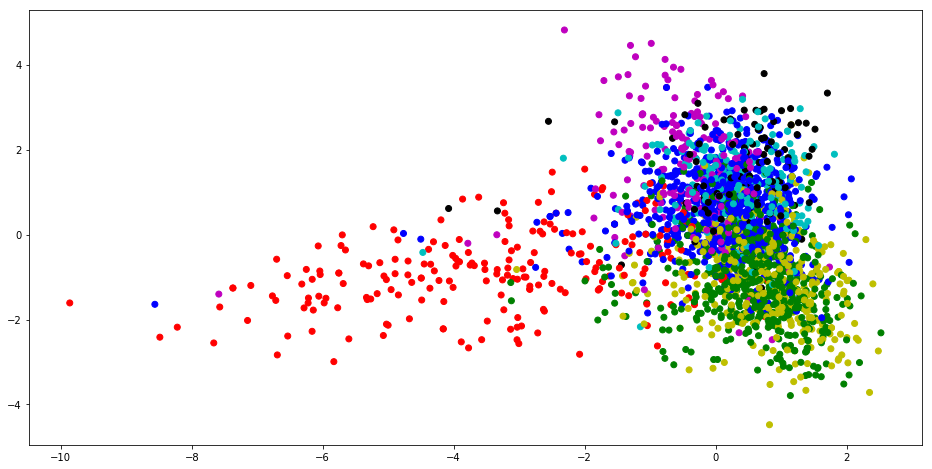

In [38]:
plt.figure(figsize=(16,8))
plt.scatter(X_reduced['x'], X_reduced['y'], color=X_reduced['color'])

We can observe that only red is out of the mass, which is category 0: animales.
Green (category 1: familia) and yellow (cat 5: sexo) are similar.
And the rest is a mess.

Thank you for joining this workshop!